---

Created for [learn-investments.rice-business.org](https://learn-investments.rice-business.org)
    
By [Kerry Back](https://kerryback.com) and [Kevin Crotty](https://kevin-crotty.com)
    
Jones Graduate School of Business, Rice University

---


# EXAMPLE TICKER

In [29]:
ticker = "WMT"

# GET DATA

In [30]:
import pandas as pd
import yfinance as yf
from pandas_datareader import DataReader as pdr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# get monthly market excess return and risk-free rate for past 60 months from French's data library
ff = pdr('F-F_Research_Data_Factors','famafrench',start=2017)[0]
ff = ff.iloc[-60:]

# get mean annual market excess return since 1926 from French's data library
mprem = pdr('F-F_Research_Data_Factors','famafrench',start=1926)[1]['Mkt-RF'].mean()

# get current 3-month Treasury bill yield from FRED
rf = pdr('DGS3MO','fred',start=2022).iloc[-1].item()

# pull data from yahoo for ticker
ret = yf.download(
    ticker,
    start='2017-01-01',
    progress=False,
    auto_adjust=False
  )['Adj Close']
ret = ret.resample('M').last().pct_change()*100
ret.index = ret.index.to_period('M')
ret.columns = ["ret"]

# merge with French data, reducing to 60 months in the process
df = ff.join(ret,how='left')

# compute excess returns for the ticker
df['ret'] -= df.RF

# RUN MARKET MODEL REGRESSION

In [31]:
import statsmodels.api as sm

# run regression of excess return on market excess return and get beta
result = sm.OLS(df.ret,sm.add_constant(df['Mkt-RF'])).fit()
beta = result.params['Mkt-RF']

# CALCULATE COST OF EQUITY

In [32]:
# compute cost of equity
eret = rf + beta*mprem


print(f'Beta:\t\t\t{beta:.2f}')
print(f'Market Risk Premium:\t{mprem:.2f}')
print(f'{ticker} Risk Premium:\t{beta*mprem:.2f}')
print(f'Risk-free Rate:\t\t{rf:.2f}')
print(f'{ticker} Cost of Equity:\t{eret:.2f}')

Beta:			0.51
Market Risk Premium:	8.80
WMT Risk Premium:	4.46
Risk-free Rate:		4.33
WMT Cost of Equity:	8.79


# FIGURE

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df[["Mkt-RF", "ret"]].reset_index()
df.columns = ["date", "mkt", "ret"]
df["date"] = df.date.astype(str)


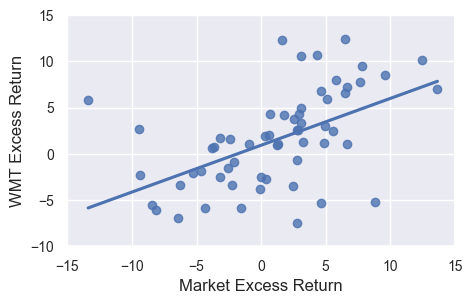

In [44]:
fig, ax = plt.subplots(figsize=(5, 3)) 
sns.set_theme(style="darkgrid")
sns.regplot(x=df.mkt, y=df.ret, ci=False, ax=ax)
# Set axis labels with larger font size
ax.set_xlabel("Market Excess Return", fontsize=12)
ax.set_ylabel(f"{ticker} Excess Return", fontsize=12)

# Set axis limits to (-15, 15)
ax.set_xlim(-15, 15)
ax.set_ylim(-10, 15)

# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=10)
plt.savefig("../posts/05-capm/capm.jpg")



In [12]:
import plotly.express as px


df['mkt'] = df['mkt']/100
df['ret'] = df['ret']/100

fig = px.scatter(
    df,
    x="mkt",
    y="ret",
    trendline="ols",
    hover_data=dict(ret=False, mkt=False, date=False),
    hover_name="date",
)

fig.update_traces(
    marker=dict(
        size=12,
        line=dict(width=2, color="DarkSlateGrey")
    ),
    selector=dict(mode="markers"),
)

fig.update_layout(
    xaxis_title="Market Excess Return",
    yaxis_title=ticker.upper() + " Excess Return",
    xaxis_tickformat=".0%",
    yaxis_tickformat=".0%",
    template="plotly"
)
fig.show()

In [16]:
fig.write_image("../posts/05-capm/capm.jpg", width=800, height=500)